# Pile of Linear Algebra Final Jupyter Notebook

Takes the original, raw, train and test csv files, and produces a deterministic test SalePrice that gives a mse of 0.12026. 

**Note:** Unfortunately, even when controlling for the random seed, different versions of python/scikit-learn/xgboost produce slighly different results. The results produced on our main test machine are attached.

The cross-validation code has been kept at the end of the notebook, after the test prediction csv file is created.

(where the team name comes from: https://xkcd.com/1838/)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import numpy as np
import scipy
import time
from scipy import stats
from scipy import special
from tqdm import tqdm
from functools import reduce

from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import RobustScaler
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LassoCV, RidgeCV, SGDRegressor, LinearRegression, ElasticNetCV
from sklearn.linear_model import LassoLarsCV, BayesianRidge, HuberRegressor, RANSACRegressor
from sklearn.linear_model import OrthogonalMatchingPursuitCV, LarsCV, LogisticRegressionCV
from sklearn.linear_model import PoissonRegressor, SGDClassifier, ARDRegression, ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge

from xgboost import XGBRegressor

pd.set_option('precision', 3)

### 1) import raw data, and remove a handful of extreme outliers

In [2]:
# load raw data
data_train = pd.read_csv('./house-prices-advanced-regression-techniques/train.csv')
data_test = pd.read_csv('./house-prices-advanced-regression-techniques/test.csv')

# remove two outliers from the training set that negatively affect most correlations
data_train.drop(data_train.loc[data_train['GrLivArea'] > 4500].index, inplace=True)

# normalize SalePrice once and store separately
train_SalePrice = np.log1p(data_train['SalePrice'])

# combine the two sets
data = pd.concat([data_train.drop('SalePrice', axis=1), data_test], keys=['train', 'test'])

# delete the two sets so that they aren't accidentally used
del data_train
del data_test

In [3]:
def rmse(actual, prediction):
    return np.sqrt(mean_squared_error(actual, prediction))

### 2) fix simple errors in each set

In [4]:
# first, in TRAIN set

# was NA, but that is invalid, set to most common
data.loc[data['Id'] == 1380, 'Electrical'] = 'SBrkr' 

# for 949, it looks like there is a basement, set default for NA
data.loc[data['Id'] == 949, 'BsmtExposure'] = False

# for 333, it looks like there is a basement, set default for NA
data.loc[data['Id'] == 333, 'BsmtFinType2'] = 'Unf'

# then, in TEST set

# for 2121, there is no basement, but several of the labels have NA instead of common defaults
data.loc[data['Id'] == 2121, 'BsmtFinSF1'] = 0
data.loc[data['Id'] == 2121, 'BsmtFinSF2'] = 0
data.loc[data['Id'] == 2121, 'BsmtFullBath'] = 0
data.loc[data['Id'] == 2121, 'BsmtHalfBath'] = 0
data.loc[data['Id'] == 2121, 'BsmtUnfSF'] = 0
data.loc[data['Id'] == 2121, 'TotalBsmtSF'] = 0

# same with 2189, no basement, just needs a default value
data.loc[data['Id'] == 2189, 'BsmtFullBath'] = 0
data.loc[data['Id'] == 2189, 'BsmtHalfBath'] = 0

# all other labels say no garage, so garage type is probably wrong
data.loc[data['Id'] == 2577, 'GarageType'] = np.nan
data.loc[data['Id'] == 2577, 'GarageCars'] = 0  # had 'NA', invalid
data.loc[data['Id'] == 2577, 'GarageArea'] = 0  # had 'NA', invalid

# looks like it has a detached garage 
data.loc[data['Id'] == 2127, 'GarageFinish'] = 'Unf'
data.loc[data['Id'] == 2127, 'GarageQual'] = 'TA'
data.loc[data['Id'] == 2127, 'GarageCond'] = 'TA'

# GarageYrBlt is clearly an error (2207), setting to year built
data.loc[data['Id'] == 2593, 'GarageYrBlt'] = data.loc[data['Id'] == 2593, 'YearBuilt']

data.loc[data['Id'] == 2525, 'BsmtCond'] = 'TA'
data.loc[data['Id'] == 2041, 'BsmtCond'] = 'TA'
data.loc[data['Id'] == 2186, 'BsmtCond'] = 'TA'
data.loc[data['Id'] == 2218, 'BsmtQual'] = 'TA'
data.loc[data['Id'] == 2219, 'BsmtQual'] = 'TA'

data.loc[data['Id'] == 1488, 'BsmtExposure'] = False
data.loc[data['Id'] == 2349, 'BsmtExposure'] = False

data.loc[data['Id'] == 1916, 'MSZoning'] = 'RM'
data.loc[data['Id'] == 2217, 'MSZoning'] = 'RM'
data.loc[data['Id'] == 2251, 'MSZoning'] = 'RM'
data.loc[data['Id'] == 2905, 'MSZoning'] = 'RL'

data.loc[data['Id'] == 1916, 'Utilities'] = 'AllPub'
data.loc[data['Id'] == 1946, 'Utilities'] = 'AllPub'

data.loc[data['Id'] == 2217, 'Functional'] = 'Typ'
data.loc[data['Id'] == 2474, 'Functional'] = 'Typ'

data.loc[data['Id'] == 2152, 'Exterior1st'] = 'VinylSd'
data.loc[data['Id'] == 2152, 'Exterior2nd'] = 'VinylSd'
data.loc[data['Id'] == 1556, 'KitchenQual'] = 'TA'
data.loc[data['Id'] == 2490, 'SaleType'] = 'WD'

# finally, get some defaults that apply to both sets

# MasVnrArea and MasVnrType cannot be NA, but rare, so set to zero (most common)
data.loc[data['MasVnrArea'].isna(), 'MasVnrArea'] = 0
data.loc[data['MasVnrType'].isna(), 'MasVnrType'] = 'None'

# if the area is greater than 0, but the type is none, set to a default
data.loc[(data['MasVnrArea'] > 0) & (data['MasVnrType']=='None'), 'MasVnrType'] = 'BrkFace'

# GarageYrBlt is only NA when there is no garage, but set to YearBuilt (acceptable dummy value)  
data.loc[data['GarageYrBlt'].isna(), 'GarageYrBlt'] = data[data['GarageYrBlt'].isna()]['YearBuilt']

# if the area is > 0, but the QC is NA, then set to mode: 'Gd'
data.loc[data['Id'] == 960, 'PoolQC'] = 'Gd'
data.loc[data['Id'] == 1043, 'PoolQC'] = 'Gd'
data.loc[data['Id'] == 1139, 'PoolQC'] = 'Gd'
data.loc[(data['PoolArea'] > 0) & (data['PoolQC'].isna()), 'PoolQC'] = 'Gd'


# for YearRemodAdd, there are no dates before 1950
# this probably means it is a default for 1950 or before (n=178 or 12%)
# removing all of the YearRemodAdd=1950, and YearRemodAdd=YearBuilt,
# and fitting a linear regression gives YearRemodAdd = 0.1059 * YearBuilt + 1789.9 (r2>0.9)
# so, for all YearRemodAdd=1950, update with a new predicted year
data.loc[(data['YearRemodAdd'] == 1950), 'YearRemodAdd'] = round(0.1059*data.loc[(data['YearRemodAdd'] == 1950), 'YearBuilt'] + 1789.9)

### 3) convert some ordinal attributes to numeric values

so that they can be combined and used mathematically

In [5]:
# convert some features to numeric ordinals (where it makes sense)

data.loc[data['LandSlope'] == 'Gtl', 'LandSlope'] = 3
data.loc[data['LandSlope'] == 'Mod', 'LandSlope'] = 2
data.loc[data['LandSlope'] == 'Sev', 'LandSlope'] = 1
data.LandSlope = data.LandSlope.astype('int64')

data.loc[data['ExterQual'] == 'Ex', 'ExterQual'] = 5
data.loc[data['ExterQual'] == 'Gd', 'ExterQual'] = 4
data.loc[data['ExterQual'] == 'TA', 'ExterQual'] = 3
data.loc[data['ExterQual'] == 'Fa', 'ExterQual'] = 2
data.loc[data['ExterQual'] == 'Po', 'ExterQual'] = 1
data.loc[data['ExterQual'].isna(), 'ExterQual'] = 0
data.ExterQual = data.ExterQual.astype('int64')

data.loc[data['ExterCond'] == 'Ex', 'ExterCond'] = 5
data.loc[data['ExterCond'] == 'Gd', 'ExterCond'] = 4
data.loc[data['ExterCond'] == 'TA', 'ExterCond'] = 3
data.loc[data['ExterCond'] == 'Fa', 'ExterCond'] = 2
data.loc[data['ExterCond'] == 'Po', 'ExterCond'] = 1
data.loc[data['ExterCond'].isna(), 'ExterCond'] = 0
data.ExterCond = data.ExterCond.astype('int64')

data.loc[data['HeatingQC'] == 'Ex', 'HeatingQC'] = 5
data.loc[data['HeatingQC'] == 'Gd', 'HeatingQC'] = 4
data.loc[data['HeatingQC'] == 'TA', 'HeatingQC'] = 3
data.loc[data['HeatingQC'] == 'Fa', 'HeatingQC'] = 2
data.loc[data['HeatingQC'] == 'Po', 'HeatingQC'] = 1
data.loc[data['HeatingQC'].isna(), 'HeatingQC'] = 0
data.HeatingQC = data.HeatingQC.astype('int64')

data.loc[data['KitchenQual'] == 'Ex', 'KitchenQual'] = 5
data.loc[data['KitchenQual'] == 'Gd', 'KitchenQual'] = 4
data.loc[data['KitchenQual'] == 'TA', 'KitchenQual'] = 3
data.loc[data['KitchenQual'] == 'Fa', 'KitchenQual'] = 2
data.loc[data['KitchenQual'] == 'Po', 'KitchenQual'] = 1
data.loc[data['KitchenQual'].isna(), 'KitchenQual'] = 0
data.KitchenQual = data.KitchenQual.astype('int64')

data.loc[data['FireplaceQu'] == 'Ex', 'FireplaceQu'] = 5
data.loc[data['FireplaceQu'] == 'Gd', 'FireplaceQu'] = 4
data.loc[data['FireplaceQu'] == 'TA', 'FireplaceQu'] = 3
data.loc[data['FireplaceQu'] == 'Fa', 'FireplaceQu'] = 2
data.loc[data['FireplaceQu'] == 'Po', 'FireplaceQu'] = 1
data.loc[data['FireplaceQu'].isna(), 'FireplaceQu'] = 0
data.FireplaceQu = data.FireplaceQu.astype('int64')

data.loc[data['GarageCond'] == 'Ex', 'GarageCond'] = 5
data.loc[data['GarageCond'] == 'Gd', 'GarageCond'] = 4
data.loc[data['GarageCond'] == 'TA', 'GarageCond'] = 3
data.loc[data['GarageCond'] == 'Fa', 'GarageCond'] = 2
data.loc[data['GarageCond'] == 'Po', 'GarageCond'] = 1
data.loc[data['GarageCond'].isna(), 'GarageCond'] = 0
data.GarageCond = data.GarageCond.astype('int64')

data.loc[data['GarageQual'] == 'Ex', 'GarageQual'] = 5
data.loc[data['GarageQual'] == 'Gd', 'GarageQual'] = 4
data.loc[data['GarageQual'] == 'TA', 'GarageQual'] = 3
data.loc[data['GarageQual'] == 'Fa', 'GarageQual'] = 2
data.loc[data['GarageQual'] == 'Po', 'GarageQual'] = 1
data.loc[data['GarageQual'].isna(), 'GarageQual'] = 0
data.GarageQual = data.GarageQual.astype('int64')

data.loc[data['GarageFinish'] == 'Fin', 'GarageFinish'] = 3
data.loc[data['GarageFinish'] == 'RFn', 'GarageFinish'] = 2
data.loc[data['GarageFinish'] == 'Unf', 'GarageFinish'] = 1
data.loc[data['GarageFinish'].isna(), 'GarageFinish'] = 0
data.GarageFinish = data.GarageFinish.astype('int64')

data.loc[data['PavedDrive'] == 'Y', 'PavedDrive'] = 2
data.loc[data['PavedDrive'] == 'P', 'PavedDrive'] = 1
data.loc[data['PavedDrive'] == 'N', 'PavedDrive'] = 0
data.PavedDrive = data.PavedDrive.astype('int64')

data.loc[data['BsmtQual'] == 'Ex', 'BsmtQual'] = 5
data.loc[data['BsmtQual'] == 'Gd', 'BsmtQual'] = 4
data.loc[data['BsmtQual'] == 'TA', 'BsmtQual'] = 3
data.loc[data['BsmtQual'] == 'Fa', 'BsmtQual'] = 2
data.loc[data['BsmtQual'] == 'Po', 'BsmtQual'] = 1
data.loc[data['BsmtQual'].isna(), 'BsmtQual'] = 0
data.BsmtQual = data.BsmtQual.astype('int64')

data.loc[data['BsmtCond'] == 'Ex', 'BsmtCond'] = 5
data.loc[data['BsmtCond'] == 'Gd', 'BsmtCond'] = 4
data.loc[data['BsmtCond'] == 'TA', 'BsmtCond'] = 3
data.loc[data['BsmtCond'] == 'Fa', 'BsmtCond'] = 2
data.loc[data['BsmtCond'] == 'Po', 'BsmtCond'] = 1
data.loc[data['BsmtCond'].isna(), 'BsmtCond'] = 0
data.BsmtCond = data.BsmtCond.astype('int64')

data.loc[data['BsmtExposure'] == 'Gd', 'BsmtExposure'] = 4
data.loc[data['BsmtExposure'] == 'Av', 'BsmtExposure'] = 3
data.loc[data['BsmtExposure'] == 'Mn', 'BsmtExposure'] = 2
data.loc[data['BsmtExposure'] == 'No', 'BsmtExposure'] = 1
data.loc[data['BsmtExposure'].isna(), 'BsmtExposure'] = 0
data.BsmtExposure = data.BsmtExposure.astype('int64')

data.loc[data['BsmtFinType1'] == 'GLQ', 'BsmtFinType1'] = 6
data.loc[data['BsmtFinType1'] == 'ALQ', 'BsmtFinType1'] = 5
data.loc[data['BsmtFinType1'] == 'BLQ', 'BsmtFinType1'] = 4
data.loc[data['BsmtFinType1'] == 'Rec', 'BsmtFinType1'] = 3
data.loc[data['BsmtFinType1'] == 'LwQ', 'BsmtFinType1'] = 2
data.loc[data['BsmtFinType1'] == 'Unf', 'BsmtFinType1'] = 1
data.loc[data['BsmtFinType1'].isna(), 'BsmtFinType1'] = 0
data.BsmtFinType1 = data.BsmtFinType1.astype('int64')

data.loc[data['BsmtFinType2'] == 'GLQ', 'BsmtFinType2'] = 6
data.loc[data['BsmtFinType2'] == 'ALQ', 'BsmtFinType2'] = 5
data.loc[data['BsmtFinType2'] == 'BLQ', 'BsmtFinType2'] = 4
data.loc[data['BsmtFinType2'] == 'Rec', 'BsmtFinType2'] = 3
data.loc[data['BsmtFinType2'] == 'LwQ', 'BsmtFinType2'] = 2
data.loc[data['BsmtFinType2'] == 'Unf', 'BsmtFinType2'] = 1
data.loc[data['BsmtFinType2'].isna(), 'BsmtFinType2'] = 0
data.BsmtFinType2 = data.BsmtFinType2.astype('int64')

data.loc[data['PoolQC'] == 'Ex', 'PoolQC'] = 5
data.loc[data['PoolQC'] == 'Gd', 'PoolQC'] = 4
data.loc[data['PoolQC'] == 'TA', 'PoolQC'] = 3
data.loc[data['PoolQC'] == 'Fa', 'PoolQC'] = 2
data.loc[data['PoolQC'] == 'Po', 'PoolQC'] = 1
data.loc[data['PoolQC'].isna(), 'PoolQC'] = 0
data.PoolQC = data.PoolQC.astype('int64')

data.loc[data['Functional'] == 'Typ', 'Functional'] = 7
data.loc[data['Functional'] == 'Min1', 'Functional'] = 6
data.loc[data['Functional'] == 'Min2', 'Functional'] = 5
data.loc[data['Functional'] == 'Mod', 'Functional'] = 4
data.loc[data['Functional'] == 'Maj1', 'Functional'] = 3
data.loc[data['Functional'] == 'Maj2', 'Functional'] = 2
data.loc[data['Functional'] == 'Sev', 'Functional'] = 1
data.loc[data['Functional'] == 'Sal', 'Functional'] = 0
data.Functional = data.Functional.astype('int64')

data.loc[data['Fence'] == 'GdPrv', 'Fence'] = 4
data.loc[data['Fence'] == 'MnPrv', 'Fence'] = 3
data.loc[data['Fence'] == 'GdWo', 'Fence'] = 2
data.loc[data['Fence'] == 'MnWw', 'Fence'] = 1
data.loc[data['Fence'].isna(), 'Fence'] = 0
data.Fence = data.Fence.astype('int64')

### 4) create additional features

In [6]:
# DateSold, to put the dates across years near each other
data['DateSold'] = data['YrSold'] + (data['MoSold'] - 0.5)/12.0

# MoSold_cos and MoSold_sin to account for seasonal variation
data['MoSold_cos'] = np.cos(2*np.pi*(data['MoSold']-1)/12)
data['MoSold_sin'] = np.sin(2*np.pi*(data['MoSold']-1)/12)

# TotalSF: GrLivArea + TotalBsmtSF
data['TotalSF'] = data['GrLivArea'] + data['TotalBsmtSF']

# TotalPorchSF: OpenPorchSF + EnclosedPorch + 3SsnPorch + ScreenPorch
data['TotalPorchSF'] = (data['OpenPorchSF'] + data['EnclosedPorch'] + 
                        data['3SsnPorch'] + data['ScreenPorch'])

# TotalBath: BsmtFullBath + BsmtHalfBath + FullBath + HalfBath
data['TotalBath'] = (data['BsmtFullBath'] + data['FullBath'] + 
                     0.5*(data['HalfBath'] + data['BsmtHalfBath']))

# AllQuality
data['AllQuality'] = (data.ExterQual + data.FireplaceQu + data.GarageQual + data.KitchenQual +
                  data.BsmtQual + data.BsmtExposure + data.BsmtFinType1 + data.PoolQC +
                  data.ExterCond + data.BsmtCond + data.GarageCond + data.OverallCond +
                  data.BsmtFinType2 + data.HeatingQC + 5*data.OverallQual)

# AllQualityLimited
data['AllQualityLimited'] = data.HeatingQC + data.PoolQC + data.FireplaceQu + data.KitchenQual

# Remodeled (if the year built is different)
data['Remodeled'] = -1
data.loc[(data.YearBuilt != data.YearRemodAdd), 'Remodeled'] = 1
data.loc[(data.YearBuilt == data.YearRemodAdd), 'Remodeled'] = 0

# New house (if built the same year sold)
data['New'] = -1
data.loc[(data.YearBuilt == data.YrSold), 'New'] = 1
data.loc[(data.YearBuilt != data.YrSold), 'New'] = 0

# Age of house
data['Age'] = -1
data.Age = data.YrSold - data.YearRemodAdd 

# average size of rooms
data['AvgRoomSize'] = data.GrLivArea / data.TotRmsAbvGrd

# has second floor
data['Has2ndFloor'] = 1 * (data['2ndFlrSF'] > 0)

In [7]:
# remove Id column (no longer used below here)
data_test_ids = data.loc['test']['Id']
del data['Id']

### 5) split categories (manually)

In [8]:
def split_into_categories(df, category_list, remove_original=True, exclude_most_common=False):
    columns_to_remove = []

    for i, column_name in enumerate(df.keys()):
        unique_category_list = pd.unique(df[column_name])

        if column_name in category_list:
            columns_to_remove.append(column_name)
            
            # sort them, if possible
            try:
                unique_category_list = np.sort(unique_category_list)
            except:
                unique_category_list = unique_category_list
            
            category_count = len(unique_category_list)
            
            # clean up category list
            unique_category_list_clean = unique_category_list.copy().astype('str')
            for cat_i in range(category_count):
                unique_category_list_clean[cat_i] = str(unique_category_list[cat_i]).replace(" ", "_")
            
            print(column_name, 'has', len(unique_category_list), 'values:', unique_category_list)
            
            # get counts
            counts = np.zeros([category_count])
            for cat_i in range(category_count):
                if str(unique_category_list[cat_i]) == "nan":
                    counts[cat_i] = len(df.loc[df[column_name].isna()].index)
                else:
                    counts[cat_i] = len(df.loc[df[column_name] == unique_category_list[cat_i]].index)
            indexes = np.where(counts == max(counts))
            max_index = indexes[0][0]  # take only the first index found

            # now, append and clean up
            for cat_i in range(category_count): 
                new_column_name = column_name + '_' + str(unique_category_list[cat_i])
                if exclude_most_common and (cat_i == max_index):
                    continue
                
                # check if string, or NaN
                if str(unique_category_list[cat_i]) == "nan":
                    df[new_column_name] = ((df[column_name].isna()) * 1.0)
                else:
                    df[new_column_name] = ((df[column_name] == unique_category_list[cat_i]) * 1.0)
    
    if remove_original:
        # now remove those columns from the concatenated data
        for i, column_name in enumerate(columns_to_remove):
            del df[column_name]
    
    return df

In [9]:
# split the obvious categorical data (that has no ordinal-like value)
categories = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 
              'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 
              'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 
              'Heating', 'CentralAir', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 
              'SaleCondition']

data = split_into_categories(data, categories, True, False)  # remove the original attribute

MSZoning has 5 values: ['C (all)' 'FV' 'RH' 'RL' 'RM']
Street has 2 values: ['Grvl' 'Pave']
Alley has 3 values: [nan 'Grvl' 'Pave']
LotShape has 4 values: ['IR1' 'IR2' 'IR3' 'Reg']
LandContour has 4 values: ['Bnk' 'HLS' 'Low' 'Lvl']
Utilities has 2 values: ['AllPub' 'NoSeWa']
LotConfig has 5 values: ['Corner' 'CulDSac' 'FR2' 'FR3' 'Inside']
Neighborhood has 25 values: ['Blmngtn' 'Blueste' 'BrDale' 'BrkSide' 'ClearCr' 'CollgCr' 'Crawfor'
 'Edwards' 'Gilbert' 'IDOTRR' 'MeadowV' 'Mitchel' 'NAmes' 'NPkVill'
 'NWAmes' 'NoRidge' 'NridgHt' 'OldTown' 'SWISU' 'Sawyer' 'SawyerW'
 'Somerst' 'StoneBr' 'Timber' 'Veenker']
Condition1 has 9 values: ['Artery' 'Feedr' 'Norm' 'PosA' 'PosN' 'RRAe' 'RRAn' 'RRNe' 'RRNn']
Condition2 has 8 values: ['Artery' 'Feedr' 'Norm' 'PosA' 'PosN' 'RRAe' 'RRAn' 'RRNn']
BldgType has 5 values: ['1Fam' '2fmCon' 'Duplex' 'Twnhs' 'TwnhsE']
HouseStyle has 8 values: ['1.5Fin' '1.5Unf' '1Story' '2.5Fin' '2.5Unf' '2Story' 'SFoyer' 'SLvl']
RoofStyle has 6 values: ['Flat' 'Gable' 

In [10]:
# split some numerical columns into seperate categories 
categories = ['MSSubClass', 'YrSold', 'MoSold', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
              'BsmtFinType2', 'BsmtQual', 'ExterCond', 'ExterQual', 'Fence', 'FireplaceQu', 
              'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'HeatingQC', 
              'KitchenQual', 'LandSlope', 'OverallCond', 'OverallQual', 'PoolQC', 'PavedDrive',
              'Fireplaces']

data = split_into_categories(data, categories, False, False)  # keep the original attribute

MSSubClass has 16 values: [ 20  30  40  45  50  60  70  75  80  85  90 120 150 160 180 190]
LandSlope has 3 values: [1 2 3]
OverallQual has 10 values: [ 1  2  3  4  5  6  7  8  9 10]
OverallCond has 9 values: [1 2 3 4 5 6 7 8 9]
ExterQual has 4 values: [2 3 4 5]
ExterCond has 5 values: [1 2 3 4 5]
BsmtQual has 5 values: [0 2 3 4 5]
BsmtCond has 5 values: [0 1 2 3 4]
BsmtExposure has 5 values: [0 1 2 3 4]
BsmtFinType1 has 7 values: [0 1 2 3 4 5 6]
BsmtFinType2 has 7 values: [0 1 2 3 4 5 6]
HeatingQC has 5 values: [1 2 3 4 5]
KitchenQual has 4 values: [2 3 4 5]
Functional has 7 values: [1 2 3 4 5 6 7]
Fireplaces has 5 values: [0 1 2 3 4]
FireplaceQu has 6 values: [0 1 2 3 4 5]
GarageFinish has 4 values: [0 1 2 3]
GarageQual has 6 values: [0 1 2 3 4 5]
GarageCond has 6 values: [0 1 2 3 4 5]
PavedDrive has 3 values: [0 1 2]
PoolQC has 4 values: [0 2 4 5]
Fence has 5 values: [0 1 2 3 4]
MoSold has 12 values: [ 1  2  3  4  5  6  7  8  9 10 11 12]
YrSold has 5 values: [2006 2007 2008 2009 201

In [11]:
# check for how many unique values in each column there are
# if there are any with only 1 unique value in the training set, then the column could be removed
print('check test set for empty columns in training set:')
for i, column_name in enumerate(data.keys()):
    unique_values = pd.unique(data.loc['train'][column_name])
    
    if len(unique_values) < 2:
        print('delete column: ', column_name)
        del data[column_name]

check test set for empty columns in training set:
delete column:  MSSubClass_150
delete column:  Fireplaces_4


### 6) Deskew and normalize the numeric data
(skipping some attributes that we wish to leave alone)

All deskew and normalization metrics are taken from **only** the training set, and applied to all data.

In [12]:
def deskew_data(df, column_name):
    skew_before = df[column_name].skew()
    
    # test for a threshold to deskew
    if abs(skew_before) > 0.75:
        # get lambda from just the train data
        training_lmbda = stats.boxcox_normmax(df.loc['train', column_name] + 1)
        
        # apply boxcox to all data
        df[column_name] = special.boxcox1p(df[column_name], training_lmbda)
        skew_after = df[column_name].skew()
        
        print(column_name, 'deskewed ({:.4f} -> {:.4f})'.format(skew_before, skew_after))

    return df

def normalize_data(df, column_name):
    max_allowed_value = 2.5
    
    train_values = df.loc['train', column_name].values
    
    # robustly z-score the data
    # get stats from just the train data
    mad = stats.median_abs_deviation(train_values)
    mad = max(mad, 1.0)  # prevent divide by zero
    median = np.median(train_values)
    
    # apply to all data
    df[column_name] = (df[column_name] - median) / mad
    
    # constrain to +/- max_allowed_value
    # this will help speed up training for some methods
    max_value = np.max(np.abs(df.loc['train', column_name].values))
    
    if max_value > max_allowed_value:
        max_value = max_value / max_allowed_value
        df[column_name] = df[column_name] / max_value
    
    return df


In [13]:
# de-skew and normalize the data (all together), skipping columns that need to be left alone for now
# skip LotFrontage and all small-value columns
columns_to_skip = ['LotFrontage', 'BedroomAbvGr', 'BsmtCond', 'BsmtExposure', 
                   'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 
                   'BsmtQual', 'ExterCond', 'ExterQual', 'Fence', 'FireplaceQu', 
                   'Fireplaces', 'FullBath', 'Functional', 'GarageCars', 
                   'GarageCond', 'GarageFinish', 'GarageQual', 'HalfBath', 
                   'HeatingQC', 'KitchenAbvGr', 'KitchenQual', 'LandSlope', 
                   'OverallCond', 'OverallQual', 'PavedDrive', 'PoolQC', 
                   'TotalBath', 'TotRmsAbvGrd', 'New', 'Remodeled', 'YearBuilt',
                   'YearRemodAdd', 'Age', 'GarageYrBlt', 'Has2ndFloor']

# deskew and normalize all of the remaining numeric columns 
for i in range(len(data.keys())):
    column_name = data.keys()[i]
    
    # make sure it isn't a column to skip
    if (not '_' in column_name and (not column_name in columns_to_skip)):
        # print(column_name)
        data = deskew_data(data, column_name)
        data = normalize_data(data, column_name)

MSSubClass deskewed (1.3758 -> 0.4232)
LotArea deskewed (13.1162 -> -0.5431)
MasVnrArea deskewed (2.6231 -> 0.9784)
BsmtFinSF1 deskewed (0.9811 -> 0.4677)
BsmtFinSF2 deskewed (4.1466 -> 2.5911)
BsmtUnfSF deskewed (0.9202 -> 0.0611)
1stFlrSF deskewed (1.2579 -> 0.0251)
2ndFlrSF deskewed (0.8620 -> 0.9393)
LowQualFinSF deskewed (12.0908 -> 8.4841)
GrLivArea deskewed (1.0693 -> 0.0618)
WoodDeckSF deskewed (1.8457 -> 0.8312)
OpenPorchSF deskewed (2.5307 -> 0.6308)
EnclosedPorch deskewed (4.0044 -> 2.1959)
3SsnPorch deskewed (11.3779 -> 8.8435)
ScreenPorch deskewed (3.9471 -> 3.1109)
PoolArea deskewed (17.6978 -> 16.4731)
MiscVal deskewed (21.9510 -> 5.2544)


/home/adammj/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/adammj/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:3943: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


TotalSF deskewed (1.0123 -> 0.0907)
TotalPorchSF deskewed (2.2457 -> 0.3735)
AvgRoomSize deskewed (0.9322 -> 0.0907)


In [14]:
# also normalize the year and age variables to be the same range
data.YearBuilt = (data.YearBuilt - 1950) / 100
data.YearRemodAdd = (data.YearRemodAdd - 1950) / 100
data.GarageYrBlt = (data.GarageYrBlt - 1950) / 100
data.Age = data.Age / 100

### 7) fix missing LotFrontage values by regression
done after all the previous steps, so that it can make use of all transformed data

iter: 0  error: 12.505


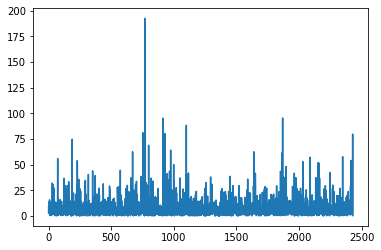

In [15]:
# create temp copies so that they can be manipulated
data_lf_fix = data.copy()

max_i = 1  # previously used multiple iterations that removed outliers, but no longer does more than 1
for iteration_i in range(max_i):

    # clean up LotFrontage in both sets (using only data from training set)
    data_lotfrontage = data_lf_fix.copy()

    # remove the rows that don't have LotFrontage
    data_lotfrontage = data_lotfrontage[~data_lotfrontage.LotFrontage.isna()]
    lotfrontage_target = data_lotfrontage['LotFrontage']
    del data_lotfrontage['LotFrontage']

    # create the model and fit it to the data
    lf_model = RidgeCV(normalize=True, alphas=0.05)
    lf_model.fit(data_lotfrontage, np.log1p(lotfrontage_target))
    prediction = np.expm1(lf_model.predict(data_lotfrontage))

    # print out the error and a graph
    print("iter: {}  error: {:.3f}".format(iteration_i, rmse(lotfrontage_target, prediction)))
    
    if iteration_i < (max_i - 1):
        # find the largest error and set it to NaN (of the copied dataset)
        max_index = (prediction - lotfrontage_target).abs().idxmax()
        data_lf_fix.loc[max_index[0]].loc[max_index[1]].loc['LotFrontage'] = np.nan

plt.plot(np.abs(prediction - lotfrontage_target).values)
plt.show()

In [16]:
# function to clean up data
def fix_lotfrontage_in_set(data_set, model, lotfrontage_target):
    data_set_local = data_set.copy()
    data_set_local = data_set_local[data_set_local.LotFrontage.isna()]
    del data_set_local['LotFrontage']

    # predict
    new_lf_values = model.predict(data_set_local)
    new_lf_values = np.expm1(new_lf_values)

    # slight clean up
    new_lf_values[new_lf_values > max(lotfrontage_target)] = max(lotfrontage_target)
    new_lf_values[new_lf_values < min(lotfrontage_target)] = min(lotfrontage_target)
    
    # store the new values
    data_set.loc[data_set.LotFrontage.isna(), 'LotFrontage'] = new_lf_values
    
    return data_set

# create fresh copy
data_lf_fix = data.copy()

# fill in the missing LotFrontage values in both sets
data_lf_fix = fix_lotfrontage_in_set(data_lf_fix, lf_model, lotfrontage_target)

# now, copy LotFrontage values into the original sets
data['LotFrontage'] = data_lf_fix['LotFrontage']

In [17]:
# now de-skew and normalize LotFrontage
data = deskew_data(data, 'LotFrontage')
data = normalize_data(data, 'LotFrontage')

LotFrontage deskewed (1.0071 -> -0.1481)


### 7) train on the training data

In [18]:
# now, split the data back out again
data_train = data.loc['train'].copy()
data_test = data.loc['test'].copy()

# delete the combined set so that it isn't accidentally used
del data

In [19]:
# for crossvalidation, add the saleprice back to the training set
data_train['SalePrice'] = train_SalePrice

In [20]:
# create backup copies to copy from
data_train_org = data_train.copy()
data_test_org = data_test.copy()

In [21]:
# try to make deterministic
random_seed = 714
np.random.seed(random_seed)
random.seed(random_seed)

In [22]:
# create models used
model_1 = KernelRidge(alpha=0.6, kernel='poly', degree=2, coef0=2.5)
model_2 = ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=random_seed)
model_3 = GradientBoostingRegressor(loss='huber', max_depth=4, n_estimators=2800, 
                                    learning_rate=0.05, max_features='sqrt', 
                                    min_samples_leaf=15, min_samples_split=10, 
                                    random_state=random_seed)

estimators=[('model_1', model_1),
            ('model_2', model_2),
            ('model_3', model_3)]
model_meta = Lasso(alpha=0.0005, random_state=random_seed)
model_stacked = StackingRegressor(estimators, final_estimator=model_meta)
model_stacked_alpha = 0.7

model_xgb = XGBRegressor(gamma=0.047, max_depth=3, learning_rate=0.05, 
                         reg_alpha=0.46, colsample_bytree=0.46, min_child_weight=1.78, 
                         n_estimators=2000, reg_lambda=0.86, subsample=0.52, 
                         random_state=random_seed)

In [23]:
# just in case, generate a fresh copy
data_train_copy = data_train_org.copy()
data_train_copy_price = data_train_copy['SalePrice']
del data_train_copy['SalePrice']

# train on the training set
model_stacked.fit(data_train_copy, data_train_copy_price);
model_xgb.fit(data_train_copy, data_train_copy_price);

# predict on the training set
stacked_prediction = model_stacked.predict(data_train_copy)
xgb_prediction = model_xgb.predict(data_train_copy)

# combine the two models (scale up, then multiply by alpha, then scale back)
prediction = np.log1p(np.expm1(stacked_prediction)*model_stacked_alpha + np.expm1(xgb_prediction)*(1-model_stacked_alpha))
print('train rmse: {:.5f}'.format(rmse(data_train_copy_price, prediction)))

train rmse: 0.07364


### 8) predict the test SalePrice

In [24]:
# now, predict using the test set
data_test_copy = data_test_org.copy()
test_stacked_prediction = np.expm1(model_stacked.predict(data_test_copy))
test_xgb_prediction = np.expm1(model_xgb.predict(data_test_copy))

# already scaled up
test_prediction = test_stacked_prediction*model_stacked_alpha + test_xgb_prediction*(1-model_stacked_alpha)

# create prediction table and save
prediction = pd.DataFrame(columns=['Id', 'SalePrice'])
prediction['Id'] = data_test_ids
prediction['SalePrice'] = test_prediction
prediction.to_csv('test_prediction.csv', index=False)

### 9) determine the feature importance

In [25]:
# calculate the importance using permutation
result_stacked = permutation_importance(model_stacked, data_train_copy, data_train_copy_price,
                                        n_repeats=10, n_jobs=-1, random_state = random_seed)

result_xgb = permutation_importance(model_xgb, data_train_copy, data_train_copy_price,
                                    n_repeats=10, n_jobs=-1, random_state = random_seed)

In [26]:
# build dataframes based on the results
importance_stacked = pd.DataFrame(columns=['column', 'mean', 'std'])
importance_stacked['column'] = data_train_copy.keys()
importance_stacked['mean'] = result_stacked.importances_mean
importance_stacked['std'] = result_stacked.importances_std

importance_xgb = pd.DataFrame(columns=['column', 'mean', 'std'])
importance_xgb['column'] = data_train_copy.keys()
importance_xgb['mean'] = result_xgb.importances_mean
importance_xgb['std'] = result_xgb.importances_std

# normalize each so that the absolute sum of the mean importances is 1
importance_stacked['mean'] = importance_stacked['mean'].values * (1.0/np.sum(abs(importance_stacked['mean'].values)))
importance_xgb['mean'] = importance_xgb['mean'].values * (1.0/np.sum(abs(importance_xgb['mean'].values)))

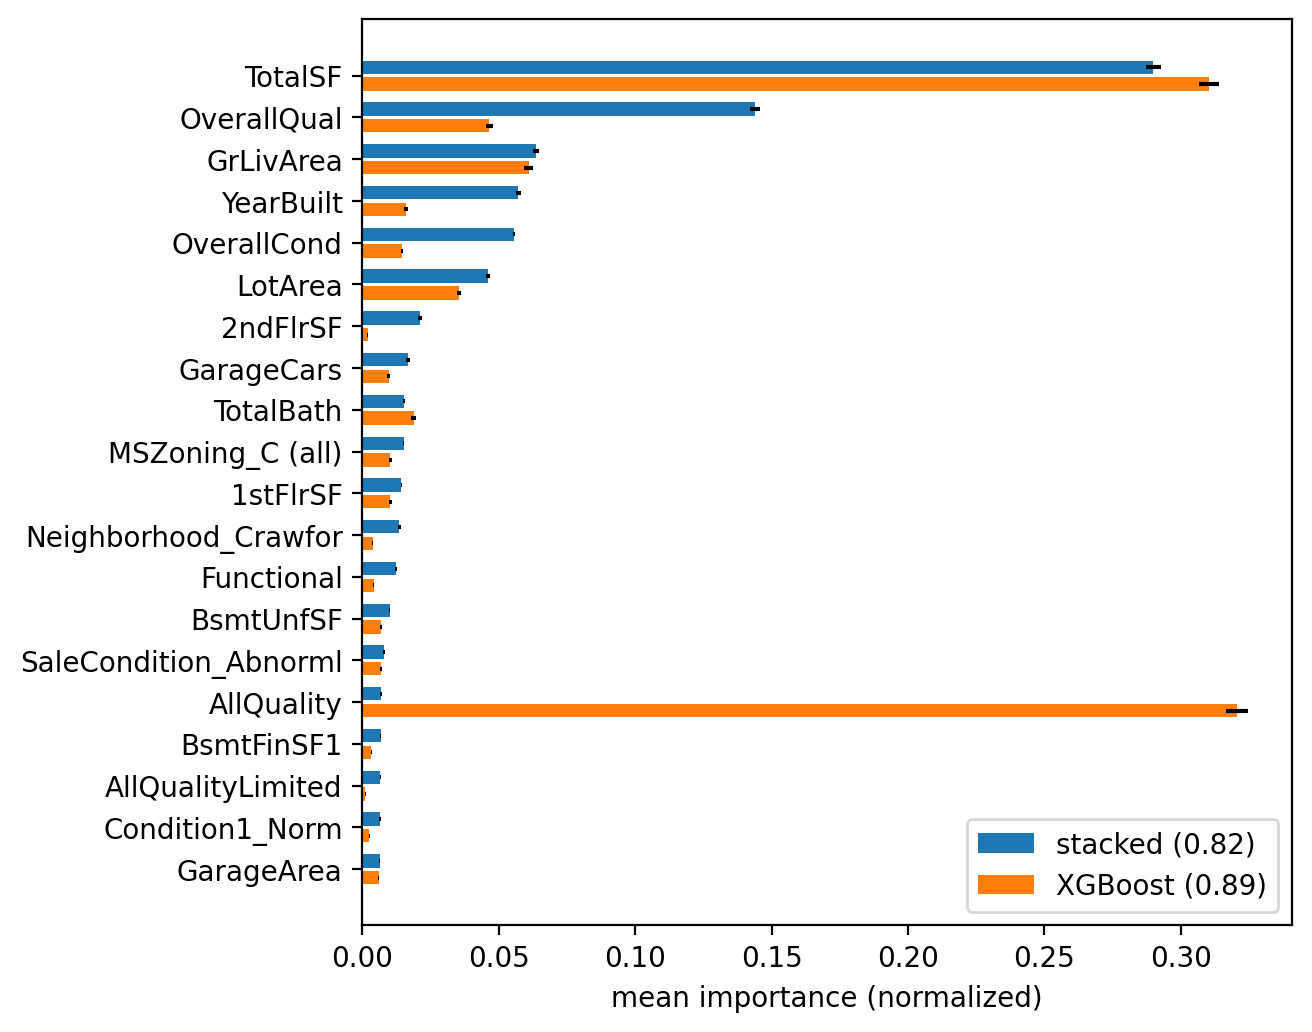

In [50]:
# plot the feature importance
# select the most important features from the stacked set, in descending order
importance_indexes = importance_stacked.loc[abs(importance_stacked['mean']) > 0].sort_values(by=['mean'], ascending=False).index

# only take the 20 largest
importance_indexes = importance_indexes[0:20]
labels_stacked = importance_stacked.iloc[importance_indexes]['column'].values
y_pos = np.arange(len(labels_stacked))

# build a second xgb dataframe that is ordered in the same way that the stacked labels are provided
xgb_temp = reduce(pd.DataFrame.append, map(lambda i: importance_xgb[importance_xgb.column == i], labels_stacked))

stack_sum = importance_stacked.iloc[importance_indexes]['mean'].values.sum()
xgb_sum = xgb_temp['mean'].values.sum()

plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['figure.dpi'] = 200
fig, ax = plt.subplots()
ax.barh(y_pos*2.5, importance_stacked.iloc[importance_indexes]['mean'].values,
        xerr=importance_stacked.iloc[importance_indexes]['std'].values, label='stacked ({:.2f})'.format(stack_sum))
ax.barh(y_pos*2.5+1, xgb_temp['mean'].values,
        xerr=xgb_temp['std'].values, label='XGBoost ({:.2f})'.format(xgb_sum))
ax.set_yticks(y_pos*2.5+0.5)
ax.set_yticklabels(labels_stacked)
ax.invert_yaxis()
plt.xlabel('mean importance (normalized)')
plt.legend()
plt.show()

### X) cross-validation of train set

kept to show results of cross-validation

In [ ]:
folds = 5
iterations = 10  # iterations to give better estimates of error (mean and std)

org_len = len(data_train.index.values)
test_fold_size = math.ceil(org_len/folds)

# try to make deterministic
np.random.seed(random_seed)
random.seed(random_seed)

# list of hypervalues to try
hypervalues = [0.46]

print('begin cross-validation testing:')
time.sleep(0.5)
start_t = time.perf_counter()

for hypervalue in hypervalues:
    if len(hypervalues) > 1:
        print('hyperparameter value:', hypervalue)
        time.sleep(0.5)
    
    # create a fresh copy for each hypervalue test
    data_train = data_train_org.copy()
       
    # create rmse array for each hypervalue test
    rmse_array = np.zeros([iterations, folds])
    
    # iterations
    for iteration_i in tqdm(range(iterations)):

        # create a list of indexes, shuffle, and reshape
        cv_indexes = np.ones(test_fold_size*folds) * np.nan  # nan will force it to catch any index errors
        cv_indexes[0:len(data_train.index.values)] = data_train.index.values.copy()

        # fill in extra randomly selected indexes to create evenly-sized folds
        if len(cv_indexes) - org_len > 0:
            # make sure to choose valid indexes
            cv_indexes[org_len:] = np.random.choice(data_train.index.values, len(cv_indexes) - org_len)

        # suffle and reshape
        np.random.shuffle(cv_indexes)
        train_idx = cv_indexes.reshape(folds, -1)
        
        # list of models for doing a naive average
        models = []
       
        model_1 = KernelRidge(alpha=0.6, kernel='poly', degree=2, coef0=2.5)
        model_2 = ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=random_seed)
        model_3 = GradientBoostingRegressor(loss='huber', max_depth=4, n_estimators=2800, 
                                            learning_rate=0.05, max_features='sqrt', 
                                            min_samples_leaf=15, min_samples_split=10, 
                                            random_state=random_seed)
        
        estimators=[('model_1', model_1),
                    ('model_2', model_2),
                    ('model_3', model_3)]
        model_meta = Lasso(alpha=0.0005, random_state=random_seed)
        model_stacked = StackingRegressor(estimators, final_estimator=model_meta)
        model_stacked_alpha = 0.7
                
        model_xgb = XGBRegressor(gamma=0.047, max_depth=3, learning_rate=0.05, 
                                 reg_alpha=0.46, colsample_bytree=0.46, min_child_weight=1.78, 
                                 n_estimators=2000, reg_lambda=0.86, subsample=0.52, 
                                 random_state=random_seed)
    
        # minimize nuisance warnings
        @ignore_warnings(category=ConvergenceWarning)
        def run_models(models, train_data, train_values, test_data, model_i=-1):
            if model_i > -1:
                models[model_i].fit(train_data, train_values)
                prediction = models[model_i].predict(test_data)

            else:
                # train the models
                model_stacked.fit(train_data, train_values)
                model_xgb.fit(train_data, train_values)
                
                # predict on the test data
                stacked_prediction = model_stacked.predict(test_data)
                xgb_prediction = model_xgb.predict(test_data)
                
                # combine the two models (scale up, then multiply by alpha, then scale back)
                prediction = np.log1p(np.expm1(stacked_prediction)*model_stacked_alpha + np.expm1(xgb_prediction)*(1-model_stacked_alpha))

            return prediction
    
        
        for fold_i in range(folds):
            # create the two cross-validation sets (using copies)
            cv_train = data_train.loc[~data_train.index.isin(train_idx[fold_i])].copy()
            cv_test = data_train.loc[train_idx[fold_i]].copy()

            # copy the prices out
            cv_train_price = cv_train['SalePrice'].copy()
            cv_test_price = cv_test['SalePrice'].copy()

            # delete those columns so they aren't used
            del cv_train['SalePrice']
            del cv_test['SalePrice']
            
            # test
            cv_test_price_prediction = run_models(models, cv_train, cv_train_price, cv_test, -1)

            # calculate and store the rmse
            rmse_array[iteration_i, fold_i] = rmse(cv_test_price, cv_test_price_prediction)
    
    # print final stats (per hyperparameter)
    print('rmse  mean: {:.5f}  std: {:.5f}'.format(np.mean(rmse_array), np.std(rmse_array)))

print('took {:.1f} sec'.format(time.perf_counter() - start_t))